In [2]:
import rasterio
from rasterio.windows import from_bounds
import numpy as np
import matplotlib.pyplot as plt
import requests

print(f"rasterio version: {rasterio.__version__}")

rasterio version: 1.4.4


In [9]:
api_url = "https://8cc8250qpj.execute-api.ap-northeast-1.amazonaws.com/prod"
response = requests.get(f"{api_url}/search", params={
    "collections": "kasugai-station",
    "limit": 10
})
data = response.json()
print(f"検索結果: {data['numberMatched']} 件")
for f in data['features'][:5]:
    print(f"  - {f['id']} (EPSG:{f['properties'].get('proj:epsg', 'N/A')})")

検索結果: 25 件
  - kasugai-dem (EPSG:4326)
  - kasugai-station (EPSG:6676)
  - 春日居町駅 (42 LAS files merged) (EPSG:6676)


In [10]:
# 春日居町駅周辺の DEM (EPSG:6676)
dem_url = "https://stac.uixai.org/data/kasugai_dem_2024_official_jgd.cog.tif"

with rasterio.open(dem_url) as src:
    print("=== 春日居町 DEM 情報 ===")
    print(f"座標系: {src.crs}")
    print(f"解像度: {src.res[0]:.2f} m")
    print(f"サイズ: {src.width} x {src.height} pixels")
    print(f"範囲: {src.bounds}")

=== 春日居町 DEM 情報 ===
座標系: EPSG:6676
解像度: 0.50 m
サイズ: 5600 x 3600 pixels
範囲: BoundingBox(left=11600.0, bottom=-37800.0, right=14400.0, top=-36000.0)


In [12]:
# 春日居町駅周辺の分析領域 (メートル単位)
analysis_bounds = {
    "west": 12500, "east": 13000,
    "south": -37000, "north": -36500
}

with rasterio.open(dem_url) as src:
    window = from_bounds(
        analysis_bounds["west"], analysis_bounds["south"],
        analysis_bounds["east"], analysis_bounds["north"],
        src.transform
    )
    dem = src.read(1, window=window)
    nodata = src.nodata
    pixel_area = src.res[0] * src.res[1]
    
    # NoData をマスク
    if nodata is not None:
        dem = np.ma.masked_equal(dem, nodata)
    
    # 異常値もマスク (標高 -100m 以下や 5000m 以上)
    dem = np.ma.masked_outside(dem, -100, 5000)
    
    print(f"読み込み領域: {dem.shape}")
    print(f"有効ピクセル数: {dem.count()}")
    print(f"NoData 値: {nodata}")
    print(f"標高範囲: {dem.min():.1f} - {dem.max():.1f} m")
    print(f"平均標高: {dem.mean():.1f} m")

読み込み領域: (1000, 1000)
有効ピクセル数: 981448
NoData 値: 1.701410009187828e+38
標高範囲: 276.4 - 365.0 m
平均標高: 304.5 m


In [13]:
# 基準標高を計算 (マスク配列対応)
base_elevation = float(dem.mean())

flood_levels = [
    base_elevation + 1,
    base_elevation + 2, 
    base_elevation + 3,
    base_elevation + 5,
    base_elevation + 10
]

print("=== 洪水浸水シミュレーション (春日居町) ===")
print(f"基準標高: {base_elevation:.1f} m")
print(f"分析領域: 500m x 500m")
print()

# マスクされていないデータのみ使用
dem_filled = dem.filled(np.nan)

results = []
for water_level in flood_levels:
    # NaN を除外して計算
    valid_mask = ~np.isnan(dem_filled)
    inundated = (dem_filled < water_level) & valid_mask
    inundated_area = np.sum(inundated) * pixel_area
    
    depth = np.where(inundated, water_level - dem_filled, 0)
    depth = np.nan_to_num(depth, nan=0)
    inundated_volume = np.sum(depth) * pixel_area
    max_depth = np.nanmax(depth)
    
    results.append({
        'level': water_level,
        'rise': water_level - base_elevation,
        'area': inundated_area,
        'volume': inundated_volume,
        'max_depth': max_depth
    })
    
    print(f"水位 {water_level:.1f}m (+{water_level - base_elevation:.0f}m):")
    print(f"  浸水面積: {inundated_area/10000:.2f} ha")
    print(f"  浸水体積: {inundated_volume:.0f} m³")
    print(f"  最大浸水深: {max_depth:.1f} m")
    print()

=== 洪水浸水シミュレーション (春日居町) ===
基準標高: 304.5 m
分析領域: 500m x 500m

水位 305.5m (+1m):
  浸水面積: 13.43 ha
  浸水体積: 2568072 m³
  最大浸水深: 29.1 m

水位 306.5m (+2m):
  浸水面積: 13.70 ha
  浸水体積: 2703762 m³
  最大浸水深: 30.1 m

水位 307.5m (+3m):
  浸水面積: 13.98 ha
  浸水体積: 2842113 m³
  最大浸水深: 31.1 m

水位 309.5m (+5m):
  浸水面積: 14.93 ha
  浸水体積: 3131383 m³
  最大浸水深: 33.1 m

水位 314.5m (+10m):
  浸水面積: 16.62 ha
  浸水体積: 3928336 m³
  最大浸水深: 38.1 m



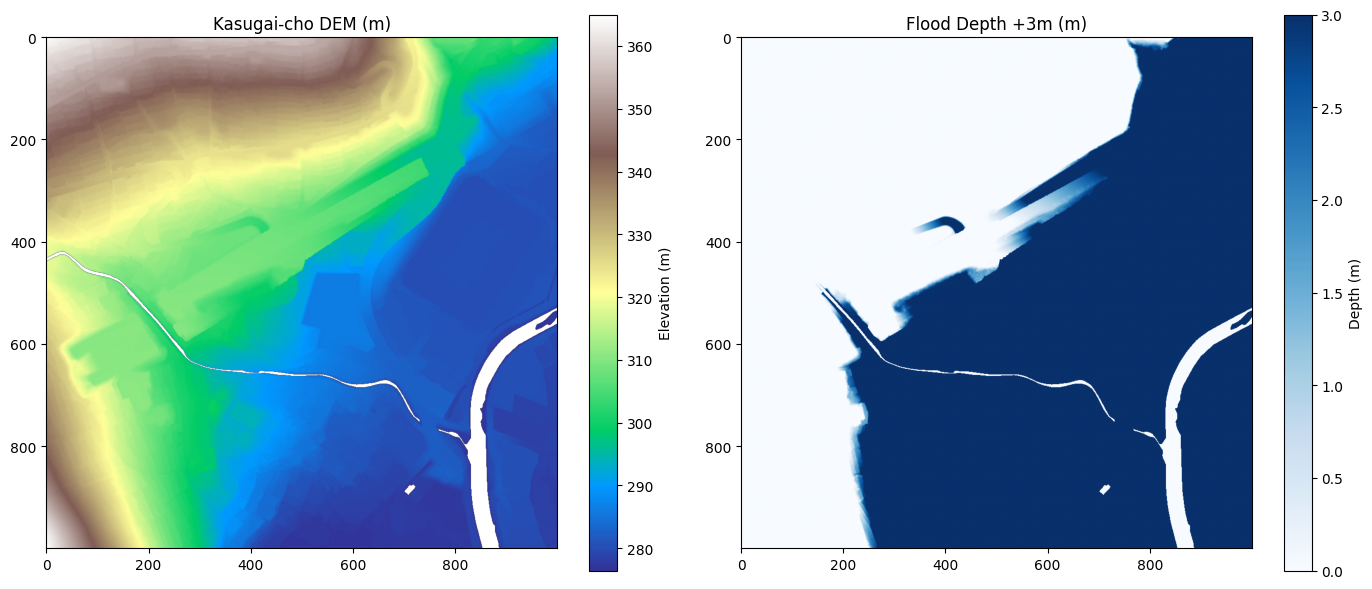

In [14]:
target_rise = 3
target_water_level = base_elevation + target_rise
flood_depth = np.maximum(0, target_water_level - dem_filled)
flood_depth = np.nan_to_num(flood_depth, nan=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# DEM (NaN はグレー表示)
im1 = axes[0].imshow(dem_filled, cmap='terrain', origin='upper')
axes[0].set_title(f'Kasugai-cho DEM (m)')
plt.colorbar(im1, ax=axes[0], label='Elevation (m)')

# 浸水深度
im2 = axes[1].imshow(flood_depth, cmap='Blues', origin='upper', vmin=0, vmax=target_rise)
axes[1].set_title(f'Flood Depth +{target_rise}m (m)')
plt.colorbar(im2, ax=axes[1], label='Depth (m)')

plt.tight_layout()
plt.savefig('kasugai_flood_simulation.png', dpi=150)
plt.show()